<a href="https://colab.research.google.com/github/kavyajeetbora/modern_geospatial_stack/blob/master/use_cases/Location_Intelligence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [54]:
!pip install -q osmnx
!pip install -q h3
!pip install -q pydeck
!pip install -q pandana

- Landuse data
- POIs

In [55]:
import osmnx as ox
import geopandas as gpd
from shapely.geometry import LineString, Point
import h3
from matplotlib import colormaps
import pydeck as pdk
import pandas as pd
import pandana as pdna

--2024-05-06 10:47:32--  https://github.com/kavyajeetbora/modern_geospatial_stack/raw/master/notebooks/gurgaon.gpkg
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kavyajeetbora/modern_geospatial_stack/master/notebooks/gurgaon.gpkg [following]
--2024-05-06 10:47:33--  https://raw.githubusercontent.com/kavyajeetbora/modern_geospatial_stack/master/notebooks/gurgaon.gpkg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98304 (96K) [application/octet-stream]
Saving to: ‘gurgaon.gpkg’

gurgaon.gpkg        100%[===================>]  96.00K  --.-KB/s    in 0.06s   

2024-05-06 10:47:33 (1.69 MB/s) - 

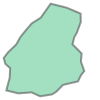

In [56]:
!wget https://github.com/kavyajeetbora/modern_geospatial_stack/raw/master/notebooks/gurgaon.gpkg -O gurgaon.gpkg

aoi = gpd.read_file("gurgaon.gpkg")['geometry'][0]
aoi

[Get OSM features from Polygon](https://osmnx.readthedocs.io/en/stable/user-reference.html#osmnx.features.features_from_polygon)

## Download the OSM Data

Download all the points of interests from OSM with the following tags:
`amenity`, `office`, `shop`

Here is a comprehensive list of [OSM features](https://wiki.openstreetmap.org/wiki/Map_features)

In [188]:
POIs = ox.features.features_from_polygon(aoi, tags={'amenity':True, 'office':True, 'shop':True, 'tourism':True}).reset_index()
POIs = POIs[POIs['geometry'].type != LineString]
POIs = POIs.to_crs('EPSG:7760')
POIs['geometry'] = POIs['geometry'].centroid
POIs = POIs.to_crs('EPSG:4326')
POIs = POIs[['osmid', 'amenity', 'name', 'geometry']]
POIs['lon'] = POIs.geometry.apply(lambda p: p.x)
POIs['lat'] = POIs.geometry.apply(lambda p: p.y)
print(f'Total points of interests found: {POIs.shape[0]}')
POIs.sample(5)

Total points of interests found: 1461


,osmid,amenity,name,geometry,lon,lat
278,2337241996,fountain,NaN,POINT (77.06424 28.46968),77.064241,28.469680
1430,1218692049,NaN,Ocus Quantum,POINT (77.06860 28.42459),77.068597,28.424586
1206,166639862,school,K.R. Mangalam World School,POINT (77.06605 28.46007),77.066054,28.460065
891,10869059265,fuel,Hindustan Petroleum,POINT (77.09453 28.47051),77.094527,28.470511
208,1390068678,NaN,NaN,POINT (77.05059 28.41716),77.050592,28.417158


## Spatial Indexing the POIs


Choosing the spatial index resolution:

<img src='https://t1nak.github.io/blog/2020/h3_pics/hex_res2.png' height=300/>

In [189]:
# find hexs containing the points

APERTURE_SIZE = 8
hex_col = 'hex'+str(APERTURE_SIZE)

delhi_gdf = POIs.copy()

delhi_gdf[hex_col] = delhi_gdf.apply(lambda x: h3.geo_to_h3(x.geometry.y,x.geometry.x,APERTURE_SIZE),1)
delhi_gdf.sample(5)

,osmid,amenity,name,geometry,lon,lat,hex8
1234,266577914,school,NaN,POINT (77.08999 28.48383),77.089994,28.483827,883da111a5fffff
125,484198838,atm,NaN,POINT (77.10336 28.49498),77.103355,28.494980,883da111a3fffff
81,416361397,fuel,NaN,POINT (77.07262 28.46393),77.072615,28.463932,883da11a83fffff
935,10952751928,NaN,Tulip Supermart,POINT (77.03171 28.39472),77.031707,28.394716,883da1182bfffff
369,4267020003,NaN,NaN,POINT (77.10162 28.48719),77.101615,28.487195,883da10349fffff


In [190]:
poi_density = delhi_gdf.groupby(hex_col)['geometry'].count().rename('poi_count').reset_index()
poi_density.sample(5)

,hex8,poi_count
98,883da11aa3fffff,11
10,883da111a1fffff,42
94,883da11a99fffff,30
72,883da118ebfffff,4
97,883da11aa1fffff,3


In [197]:
def color_code_value(value, cmap):
    color = cmap(value)
    scaled_colors = list(map(lambda x: int(x*255), color[:3]))
    scaled_alpha = int(color[3]*100)

    scaled_colors += [scaled_alpha]
    return scaled_colors

def colormap_dataframe(df, value_col, cmap):

    xdf = df.copy()

    ## Scale the temperature values between 0-1; using MinMax Scaler
    xdf[f'norm_{value_col}'] = (xdf[value_col]-xdf[value_col].min())/(xdf[value_col].max()-xdf[value_col].min())
    xdf['color'] = xdf[f'norm_{value_col}'].apply(lambda x: color_code_value(x, cmap))
    xdf[['R', 'G', 'B', 'A']] = pd.DataFrame(xdf['color'].to_list())
    xdf = xdf.drop(['color', f'norm_{value_col}'], axis=1)

    ## formatting the temperature value upto 1 decimal place
    xdf[value_col] = xdf[value_col].round(1)

    return xdf

def create_h3_hex_layer(df):

    # Define a layer to display on a map
    layer = pdk.Layer(
        "H3HexagonLayer",
        df,
        pickable=True,
        stroked=True,
        filled=True,
        extruded=False,
        get_hexagon=hex_col,
        get_fill_color="[R, G, B, A]"
    )

    return layer

tooltip = {
        "html": "Amenities Count: {poi_count}",
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }

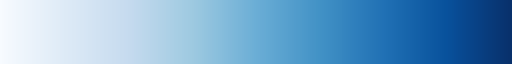

In [198]:
## Choose a colormap
cmap = colormaps['Blues']
cmap

In [199]:
## Apply the colormap to the dataframe
xdf = colormap_dataframe(df=poi_density, value_col='poi_count', cmap=cmap)

## Now create a H3HexagonLayer
layer = create_h3_hex_layer(xdf)

# Set the viewport location
x,y = aoi.centroid.x, aoi.centroid.y
view_state = pdk.ViewState(latitude=y, longitude=x, zoom=11, bearing=0, pitch=30)

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip)
r

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.437398083125167,
    "longitude": 77.06463665845695,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "A": 100,
          "B": 249,
          "G": 239,
          "R": 228,
          "hex8": "883da10341fffff",
          "poi_count": 7
        },
        {
          "A": 100,
          "B": 252,
          "G": 245,
          "R": 238,
          "hex8": "883da10345fffff",
          "poi_count": 4
        },
        {
          "A": 100,
          "B": 249,
          "G": 239,
          "R": 228,
          "hex8": "883da10349fffff",
          "poi_count": 7
        },
        {
          "A": 100,
          "B": 251,
          "G": 243,
          "R": 235,
          "hex8": "883da1034bfffff",
          "poi_count": 5
        },
        {
          "A": 100,
          "B": 252,
          "G": 245,
          "R": 238,
          "hex8": "883da1034dfffff",
          "poi_count": 4
        },
        {
          "A": 100,
          "B": 253,
          "G": 247,
          "R": 241,
          "hex8": "883da10365fffff",
          "poi_count": 3
        },
        {
          "A": 100,
          "B": 252,
          "G": 245,
          "R": 238,
          "hex8": "883da10369fffff",
          "poi_count": 4
        },
        {
          "A": 100,
          "B": 246,
          "G": 233,
          "R": 220,
          "hex8": "883da1036dfffff",
          "poi_count": 10
        },
        {
          "A": 100,
          "B": 254,
          "G": 249,
          "R": 244,
          "hex8": "883da11185fffff",
          "poi_count": 2
        },
        {
          "A": 100,
          "B": 255,
          "G": 251,
          "R": 247,
          "hex8": "883da11187fffff",
          "poi_count": 1
        },
        {
          "A": 100,
          "B": 198,
          "G": 146,
          "R": 66,
          "hex8": "883da111a1fffff",
          "poi_count": 42
        },
        {
          "A": 100,
          "B": 240,
          "G": 221,
          "R": 202,
          "hex8": "883da111a3fffff",
          "poi_count": 16
        },
        {
          "A": 100,
          "B": 241,
          "G": 223,
          "R": 205,
          "hex8": "883da111a5fffff",
          "poi_count": 15
        },
        {
          "A": 100,
          "B": 243,
          "G": 227,
          "R": 211,
          "hex8": "883da111a7fffff",
          "poi_count": 13
        },
        {
          "A": 100,
          "B": 251,
          "G": 243,
          "R": 235,
          "hex8": "883da111a9fffff",
          "poi_count": 5
        },
        {
          "A": 100,
          "B": 236,
          "G": 216,
          "R": 191,
          "hex8": "883da111abfffff",
          "poi_count": 19
        },
        {
          "A": 100,
          "B": 249,
          "G": 239,
          "R": 228,
          "hex8": "883da111adfffff",
          "poi_count": 7
        },
        {
          "A": 100,
          "B": 252,
          "G": 245,
          "R": 238,
          "hex8": "883da111b5fffff",
          "poi_count": 4
        },
        {
          "A": 100,
          "B": 255,
          "G": 251,
          "R": 247,
          "hex8": "883da111bdfffff",
          "poi_count": 1
        },
        {
          "A": 100,
          "B": 247,
          "G": 235,
          "R": 222,
          "hex8": "883da111e5fffff",
          "poi_count": 9
        },
        {
          "A": 100,
          "B": 253,
          "G": 247,
          "R": 241,
          "hex8": "883da111e7fffff",
          "poi_count": 3
        },
        {
          "A": 100,
          "B": 255,
          "G": 251,
          "R": 247,
          "hex8": "883da111ebfffff",
          "poi_count": 1
        },
        {
          "A": 100,
          "B": 244,
          "G": 229,
          "R": 214,
          "hex8": "883da11803fffff",
          "poi_count": 12
        },
        {
          "A

## Accessibility

Get the network graph for the AOI

In [200]:
G = ox.graph_from_polygon(aoi)

## Convert it to GDFs
nodes, edges = ox.convert.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True, fill_edge_geometry=True)
edges = edges.reset_index()

Create a `pandana` network from the given graph

In [203]:
network = pdna.Network(nodes["x"], nodes["y"], edges["u"], edges["v"],edges[["length"]])

## Extracting the transportation features from OSM

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Total Number of features: 144


<Axes: >

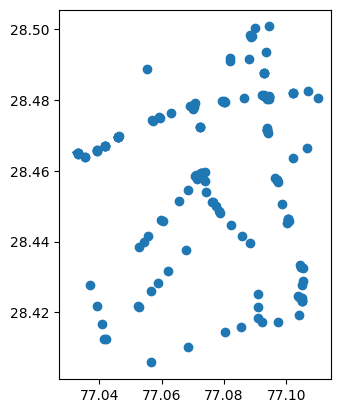

In [202]:
# xx = ox.features.features_from_polygon(aoi, tags={'healthcare':True, 'amenity':['clinic', 'doctors', 'hospital', 'dentist', 'pharmacy']})
tags={'public_transport': True, 'highway': ['primary', 'secondary', 'tertiary']}
tags={'public_transport': True}
xx = ox.features.features_from_polygon(aoi, tags=tags)
print(f'Total Number of features: {xx.shape[0]}')
xx.plot()

In [174]:
mobility = ox.features.features_from_polygon(aoi, tags=tags).reset_index()
mobility = mobility.to_crs('EPSG:7760')  ## Converting the geometries to UTM for distance calculation
mobility['geometry'] = mobility['geometry'].centroid
mobility = mobility.to_crs('EPSG:4326') ## Converting back to WGS84 for visualization
mobility = mobility[['osmid', 'public_transport', 'highway','name', 'geometry']]
mobility['lon'] = mobility.geometry.apply(lambda p: p.x)
mobility['lat'] = mobility.geometry.apply(lambda p: p.y)
print(f'Total points of interests found: {mobility.shape[0]}')
mobility.sample(5)

Total points of interests found: 144


,osmid,public_transport,highway,name,geometry,lon,lat
53,7131394591,platform,bus_stop,NaN,POINT (77.08658 28.48070),77.086585,28.480701
105,10899637071,platform,bus_stop,Sector 42/43 Metro Station,POINT (77.09747 28.45689),77.097467,28.456892
20,3953773571,station,NaN,DLF Phase 1,POINT (77.09396 28.47143),77.093961,28.471426
9,1646599506,platform,bus_stop,Huda Metro Bus Stand,POINT (77.07388 28.45972),77.073878,28.459725
92,10876163494,platform,bus_stop,Sector 55/56,POINT (77.10547 28.42889),77.105472,28.428893


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


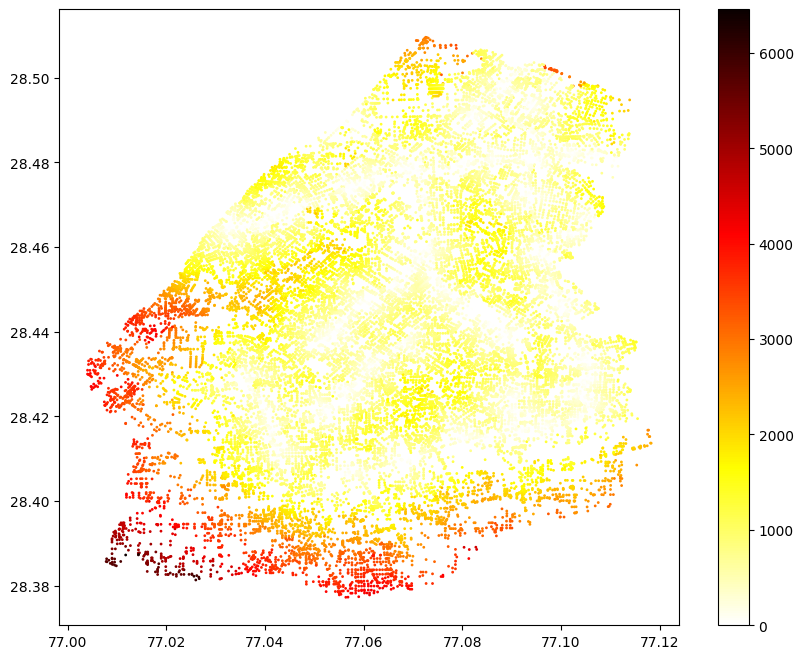

In [175]:
# initialize each amenity category with the locations (lon/lat coordinates)

max_distance=25000 ## in meters
num_pois = 1

category = 'all'
network.set_pois(category=category, maxdist = max_distance, maxitems=num_pois, x_col=mobility['lon'], y_col=mobility['lat'])
accessibility = network.nearest_pois(distance = max_distance, category=category, num_pois=num_pois)

def plot_nearest_amenity(accessibility,n):
    fig, ax = network.plot(accessibility[n]);
    ax.set_facecolor('k');
    ax.set_title('Pedestrian accessibility in Gurgaon (distance to pois, in meters (n = {}))'.format(category,n), fontsize=14);
    return fig

fig = plot_nearest_amenity(accessibility,num_pois)

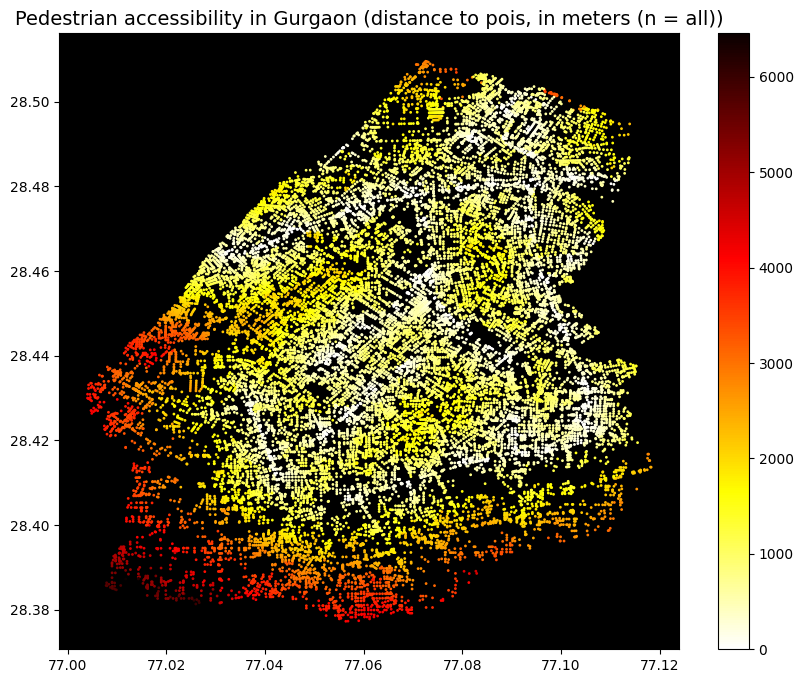

In [176]:
fig

## Converting the points to h3 spaital index

In [177]:
pedestrian_mins = accessibility.copy()

## Convert the accessibility to minutes taken to walk to the POI
walking_speed = 100 ## m/min
pedestrian_mins = pedestrian_mins/walking_speed

pedestrian_mins = nodes.join(pedestrian_mins)[['geometry', 1]].rename(columns={1:'time_min'})
pedestrian_mins[hex_col] = pedestrian_mins.apply(lambda p: h3.geo_to_h3(p.geometry.y,p.geometry.x,APERTURE_SIZE),1)
pedestrian_mins.sample(5)

,geometry,time_min,hex8
osmid,,,
6321768649,POINT (77.07330 28.44340),8.40702,883da11abdfffff
4133214163,POINT (77.08847 28.42463),2.98959,883da118c3fffff
4204666772,POINT (77.04287 28.47527),12.39760,883da11ac1fffff
7485136839,POINT (77.07928 28.45732),9.80686,883da11ab9fffff
6438261410,POINT (77.10369 28.49120),13.57561,883da111a3fffff


Aggregate the results per h3 hexagon by mean

In [178]:
agg_ped_mins = pedestrian_mins[[hex_col, 'time_min']].groupby(hex_col).mean().reset_index()
agg_ped_mins.sample(5)

,hex8,time_min
148,883da11ab3fffff,8.097388
94,883da118d1fffff,5.243786
60,883da11851fffff,7.586648
93,883da118cdfffff,13.904705
50,883da11835fffff,28.391528


In [179]:
## Apply the colormap to the dataframe
# cmap: PRGn
cmap = colormaps['YlOrRd']
xdf = colormap_dataframe(df=agg_ped_mins, value_col='time_min', cmap=cmap)

## Now create a H3HexagonLayer
layer = create_h3_hex_layer(xdf)

# Set the viewport location
x,y = aoi.centroid.x, aoi.centroid.y
view_state = pdk.ViewState(latitude=y, longitude=x, zoom=11, bearing=0, pitch=30)


tooltip = {
        "html": "Pedestrian Accessibility: {time_min} mins",
        "style": {
            "backgroundColor": "#4CAF50",   # Green shade for background
            "color": "#FFFFFF",             # White for text color
            "border": "2px solid #4CAF50",  # Matching border color
            "borderRadius": "5px",          # Rounded corners
            "boxShadow": "2px 2px 10px rgba(0, 0, 0, 0.2)"  # Soft shadow effect
        }
    }

# Render
r = pdk.Deck(layers=[layer], initial_view_state=view_state, tooltip=tooltip)
r

<IPython.core.display.Javascript object>

{
  "initialViewState": {
    "bearing": 0,
    "latitude": 28.437398083125167,
    "longitude": 77.06463665845695,
    "pitch": 30,
    "zoom": 11
  },
  "layers": [
    {
      "@@type": "H3HexagonLayer",
      "data": [
        {
          "A": 100,
          "B": 198,
          "G": 252,
          "R": 255,
          "hex8": "883da10341fffff",
          "time_min": 4.2
        },
        {
          "A": 100,
          "B": 149,
          "G": 231,
          "R": 254,
          "hex8": "883da10345fffff",
          "time_min": 11.7
        },
        {
          "A": 100,
          "B": 168,
          "G": 240,
          "R": 255,
          "hex8": "883da10349fffff",
          "time_min": 8.7
        },
        {
          "A": 100,
          "B": 134,
          "G": 225,
          "R": 254,
          "hex8": "883da1034bfffff",
          "time_min": 13.8
        },
        {
          "A": 100,
          "B": 190,
          "G": 249,
          "R": 255,
          "hex8": "883da1034dfffff",
          "time_min": 5.4
        },
        {
          "A": 100,
          "B": 173,
          "G": 242,
          "R": 255,
          "hex8": "883da10361fffff",
          "time_min": 7.7
        },
        {
          "A": 100,
          "B": 197,
          "G": 252,
          "R": 255,
          "hex8": "883da10365fffff",
          "time_min": 4.2
        },
        {
          "A": 100,
          "B": 190,
          "G": 249,
          "R": 255,
          "hex8": "883da10369fffff",
          "time_min": 5.4
        },
        {
          "A": 100,
          "B": 145,
          "G": 230,
          "R": 254,
          "hex8": "883da1036bfffff",
          "time_min": 12.1
        },
        {
          "A": 100,
          "B": 191,
          "G": 249,
          "R": 255,
          "hex8": "883da1036dfffff",
          "time_min": 5.2
        },
        {
          "A": 100,
          "B": 198,
          "G": 252,
          "R": 255,
          "hex8": "883da11137fffff",
          "time_min": 4.1
        },
        {
          "A": 100,
          "B": 168,
          "G": 240,
          "R": 255,
          "hex8": "883da11185fffff",
          "time_min": 8.7
        },
        {
          "A": 100,
          "B": 194,
          "G": 251,
          "R": 255,
          "hex8": "883da111a1fffff",
          "time_min": 4.7
        },
        {
          "A": 100,
          "B": 176,
          "G": 243,
          "R": 255,
          "hex8": "883da111a3fffff",
          "time_min": 7.4
        },
        {
          "A": 100,
          "B": 187,
          "G": 248,
          "R": 255,
          "hex8": "883da111a5fffff",
          "time_min": 5.7
        },
        {
          "A": 100,
          "B": 195,
          "G": 251,
          "R": 255,
          "hex8": "883da111a7fffff",
          "time_min": 4.5
        },
        {
          "A": 100,
          "B": 180,
          "G": 245,
          "R": 255,
          "hex8": "883da111a9fffff",
          "time_min": 6.7
        },
        {
          "A": 100,
          "B": 183,
          "G": 246,
          "R": 255,
          "hex8": "883da111abfffff",
          "time_min": 6.4
        },
        {
          "A": 100,
          "B": 198,
          "G": 252,
          "R": 255,
          "hex8": "883da111adfffff",
          "time_min": 4.1
        },
        {
          "A": 100,
          "B": 121,
          "G": 218,
          "R": 254,
          "hex8": "883da111b5fffff",
          "time_min": 16.0
        },
        {
          "A": 100,
          "B": 76,
          "G": 178,
          "R": 254,
          "hex8": "883da111b7fffff",
          "time_min": 23.0
        },
        {
          "A": 100,
          "B": 107,
          "G": 206,
          "R": 254,
          "hex8": "883da111bdfffff",
          "time_min": 18.1
        },
        {
          "A": 100,
          "B": 82,
          "G": 183,
          "R": 254,
          "hex8": "883da111e1fffff",
          "time_min": 22.2
        },


<Axes: >

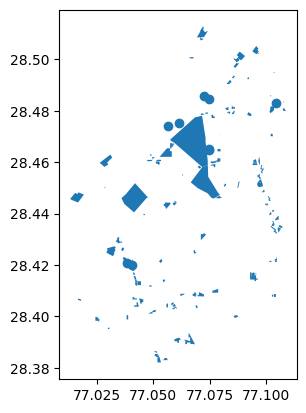

In [185]:
landuse = ox.features.features_from_polygon(aoi, tags={'landuse':['commercial']}).reset_index()
landuse.plot()

In [182]:
landuse['landuse'].value_counts()

landuse
residential          322
commercial           151
grass                100
retail                50
recreation_ground     22
construction          14
industrial            13
village_green         11
forest                 5
meadow                 4
brownfield             3
military               3
allotments             2
farmland               2
depot                  1
Pink Town House        1
religious              1
landfill               1
basin                  1
greenfield             1
conservation           1
Name: count, dtype: int64